In [1]:
import pandas as pd
import numpy as np
import json

# Plotting
import matplotlib.pyplot as plt
import football_modelling

# Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf


/Users/thomas/.pyenv/versions/3.10.0/envs/soccer/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from football_modelling.data import load_wyscout_match_data

shots_model = load_wyscout_match_data()
goals_only = shots_model[shots_model["Goal"] == 1]


In [4]:
# Get first 200 shots
shots_200 = shots_model.iloc[:200]


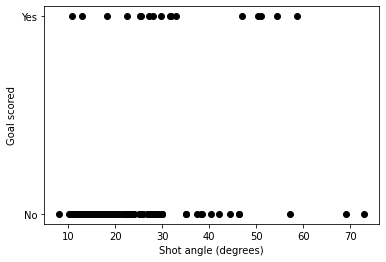

In [5]:
fig, ax = plt.subplots(num=1)
ax.plot(
    shots_200["Angle"] * 180 / np.pi,
    shots_200["Goal"],
    linestyle="none",
    marker=".",
    markersize=12,
    color="black",
)
ax.set_ylabel("Goal scored")
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05, 1.05))
ax.set_yticks([0, 1])
ax.set_yticklabels(["No", "Yes"])
plt.show()


/var/folders/tj/210mgsf94f51kmvjq04yb70c0000gn/T/ipykernel_49626/840595655.py:3: RuntimeWarning: invalid value encountered in true_divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


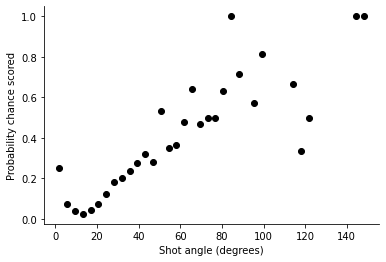

In [6]:
shotcount_dist = np.histogram(
    shots_model["Angle"] * 180 / np.pi, bins=40, range=[0, 150]
)
goalcount_dist = np.histogram(
    goals_only["Angle"] * 180 / np.pi, bins=40, range=[0, 150]
)
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:]) / 2
fig, ax = plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle="none", marker=".", markersize=12, color="black")
ax.set_ylabel("Probability chance scored")
ax.set_xlabel("Shot angle (degrees)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


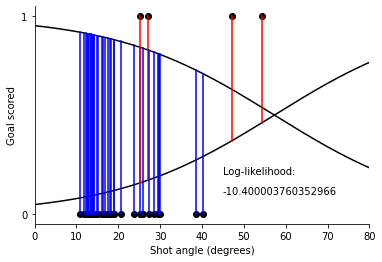

In [7]:
# Now try sigmoid model
# This is a good model but NOT a good way of fitting.
# because each point contains lots of data points
b = [3, -3]
x = np.arange(150, step=0.1)
y = 1 / (1 + np.exp(b[0] + b[1] * x * np.pi / 180))
ax.plot(x, y, linestyle="solid", color="black")
plt.show()

# Now lets look at the likelihood of model given data
xG = 1 / (1 + np.exp(b[0] + b[1] * shots_model["Angle"]))
shots_model = shots_model.assign(xG=xG)
shots_40 = shots_model.iloc[:40]
fig, ax = plt.subplots(num=1)
ax.plot(
    shots_40["Angle"] * 180 / np.pi,
    shots_40["Goal"],
    linestyle="none",
    marker=".",
    markersize=12,
    color="black",
)
ax.plot(x, y, linestyle="solid", color="black")
ax.plot(x, 1 - y, linestyle="solid", color="black")
loglikelihood = 0
for item, shot in shots_40.iterrows():
    ang = shot["Angle"] * 180 / np.pi
    if shot["Goal"] == 1:
        loglikelihood = loglikelihood + np.log(shot["xG"])
        ax.plot([ang, ang], [shot["Goal"], shot["xG"]], color="red")
    else:
        loglikelihood = loglikelihood + np.log(1 - shot["xG"])
        ax.plot([ang, ang], [shot["Goal"], 1 - shot["xG"]], color="blue")

ax.set_ylabel("Goal scored")
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05, 1.05))
plt.xlim((0, 80))
plt.text(45, 0.2, "Log-likelihood:")
plt.text(45, 0.1, str(loglikelihood))
ax.set_yticks([0, 1])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.savefig("Output/LikelihoodExample.pdf", dpi=None, bbox_inches="tight")
plt.show()


In [8]:
test_model = smf.glm(
    formula="Goal ~ Angle", data=shots_model, family=sm.families.Binomial()
).fit()
print(test_model.summary())
b = test_model.params


                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7132
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2056.3
Date:                    Wed, 05 Jan 2022   Deviance:                       4112.7
Time:                            16:57:45   Pearson chi2:                 6.70e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.08377
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

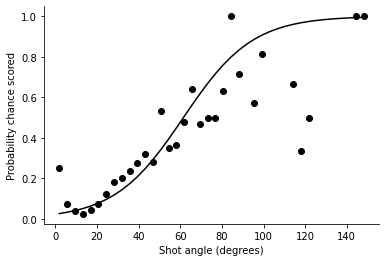

In [9]:
xGprob = 1 / (1 + np.exp(b[0] + b[1] * midangle * np.pi / 180))
fig, ax = plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle="none", marker=".", markersize=12, color="black")
ax.plot(midangle, xGprob, linestyle="solid", color="black")
ax.set_ylabel("Probability chance scored")
ax.set_xlabel("Shot angle (degrees)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()
fig.savefig("Output/ProbabilityOfScoringAngleFit.pdf", dpi=None, bbox_inches="tight")


/var/folders/tj/210mgsf94f51kmvjq04yb70c0000gn/T/ipykernel_49626/2260718135.py:7: RuntimeWarning: invalid value encountered in true_divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


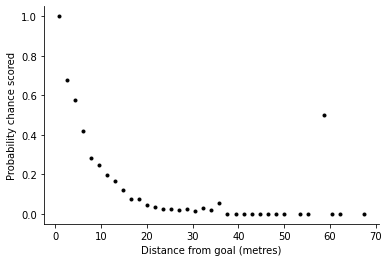

In [10]:
# Now lets look at distance from goal


# Show empirically how distance from goal predicts probability of scoring
shotcount_dist = np.histogram(shots_model["Distance"], bins=40, range=[0, 70])
goalcount_dist = np.histogram(goals_only["Distance"], bins=40, range=[0, 70])
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
distance = shotcount_dist[1]
middistance = (distance[:-1] + distance[1:]) / 2
fig, ax = plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle="none", marker=".", color="black")
ax.set_ylabel("Probability chance scored")
ax.set_xlabel("Distance from goal (metres)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


In [11]:
# Make single variable model of distance
test_model = smf.glm(
    formula="Goal ~ Distance", data=shots_model, family=sm.families.Binomial()
).fit()
print(test_model.summary())
b = test_model.params


                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7132
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2010.7
Date:                    Wed, 05 Jan 2022   Deviance:                       4021.3
Time:                            16:57:46   Pearson chi2:                 1.90e+04
No. Iterations:                         6   Pseudo R-squ. (CS):            0.09542
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [12]:
xGprob = 1 / (1 + np.exp(b[0] + b[1] * middistance))
ax.plot(middistance, xGprob, linestyle="solid", color="black")
plt.show()
fig.savefig("Output/ProbabilityOfScoringDistance.pdf", dpi=None, bbox_inches="tight")


                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7131
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1992.2
Date:                    Wed, 05 Jan 2022   Deviance:                       3984.3
Time:                            16:57:46   Pearson chi2:                 7.12e+03
No. Iterations:                         7   Pseudo R-squ. (CS):             0.1001
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

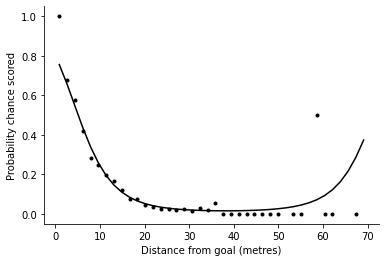

In [13]:
# Adding distance squared
squaredD = shots_model["Distance"] ** 2
shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(
    formula="Goal ~ Distance + D2", data=shots_model, family=sm.families.Binomial()
).fit()
print(test_model.summary())
b = test_model.params
xGprob = 1 / (1 + np.exp(b[0] + b[1] * middistance + b[2] * pow(middistance, 2)))
fig, ax = plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle="none", marker=".", color="black")
ax.set_ylabel("Probability chance scored")
ax.set_xlabel("Distance from goal (metres)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.plot(middistance, xGprob, linestyle="solid", color="black")
plt.show()
fig.savefig(
    "Output/ProbabilityOfScoringDistanceSquared.pdf", dpi=None, bbox_inches="tight"
)


In [14]:
shots_model


,Goal,X,Y,C,Distance,Angle,xG,D2
46,1,12,41,9.0,13.891814,0.474451,0.171271,192.9825
62,0,15,52,2.0,15.803560,0.453823,0.162665,249.7525
128,0,19,33,17.0,22.805811,0.280597,0.103567,520.1050
249,0,25,30,20.0,29.292704,0.223680,0.088753,858.0625
394,0,10,39,11.0,12.703248,0.479051,0.173239,161.3725
...,...,...,...,...,...,...,...,...
642939,0,14,40,10.0,16.072959,0.413920,0.147011,258.3400
642945,0,28,45,5.0,29.579089,0.244789,0.094009,874.9225
643023,1,14,33,17.0,18.390011,0.319916,0.115041,338.1925
643051,0,12,62,12.0,14.818907,0.420593,0.149539,219.6000


In [15]:
# Adding even more variables to the model.
squaredX = shots_model["X"] ** 2
shots_model = shots_model.assign(X2=squaredX)
squaredC = shots_model["C"] ** 2
shots_model = shots_model.assign(C2=squaredC)
AX = shots_model["Angle"] * shots_model["X"]
shots_model = shots_model.assign(AX=AX)


In [16]:
# A general model for fitting goal probability
# List the model variables you want here
model_variables = ["Angle", "Distance", "X", "C"]
model = ""
for v in model_variables[:-1]:
    model = model + v + " + "
model = model + model_variables[-1]


In [17]:
# Fit the model
test_model = smf.glm(
    formula="Goal ~ " + model, data=shots_model, family=sm.families.Binomial()
).fit()
print(test_model.summary())
b = test_model.params


                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 7134
Model:                                GLM   Df Residuals:                     7129
Model Family:                    Binomial   Df Model:                            4
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1988.0
Date:                    Wed, 05 Jan 2022   Deviance:                       3976.0
Time:                            16:57:46   Pearson chi2:                 9.33e+03
No. Iterations:                         7   Pseudo R-squ. (CS):             0.1012
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [18]:
# Return xG value for more general model
def calculate_xG(sh):
    bsum = b[0]
    for i, v in enumerate(model_variables):
        bsum = bsum + b[i + 1] * sh[v]
    xG = 1 / (1 + np.exp(bsum))
    return xG


In [19]:
# Add an xG to my dataframe
xG = shots_model.apply(calculate_xG, axis=1)
shots_model = shots_model.assign(xG=xG)


In [20]:
# Create a 2D map of xG
pgoal_2d = np.zeros((65, 65))
for x in range(65):
    for y in range(65):
        sh = dict()
        a = np.arctan(7.32 * x / (x ** 2 + abs(y - 65 / 2) ** 2 - (7.32 / 2) ** 2))
        if a < 0:
            a = np.pi + a
        sh["Angle"] = a
        sh["Distance"] = np.sqrt(x ** 2 + abs(y - 65 / 2) ** 2)
        sh["D2"] = x ** 2 + abs(y - 65 / 2) ** 2
        sh["X"] = x
        sh["AX"] = x * a
        sh["X2"] = x ** 2
        sh["C"] = abs(y - 65 / 2)
        sh["C2"] = (y - 65 / 2) ** 2

        pgoal_2d[x, y] = calculate_xG(sh)


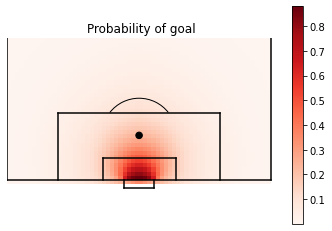

In [21]:
from football_modelling.plotting import createGoalMouth

(fig, ax) = football_modelling.plotting.createGoalMouth()
pos = ax.imshow(pgoal_2d, extent=[-1, 65, 65, -1], aspect="auto", cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title("Probability of goal")
plt.xlim((0, 66))
plt.ylim((-3, 35))
plt.gca().set_aspect("equal", adjustable="box")
plt.show()
fig.savefig("Output/goalprobfor_" + model + ".pdf", dpi=None, bbox_inches="tight")
